Template from https://www.tensorflow.org/tutorials/images/transfer_learning 

In [ ]:
!pip install tf-nightly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_path = '/content/drive/MyDrive/ML_UCL/celeba/img/'
label_path = '/content/drive/MyDrive/ML_UCL/celeba/labels.csv'

In [ ]:
df = pd.read_csv(label_path, sep='\s+')
df.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0

(5000, 3)

In [ ]:
import cv2
X = []
for x in df.img_name:
  X.append(cv2.imread(img_path + x))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df.gender, test_size= 0.2, random_state=0,stratify=df.gender)
X_train, X_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0,stratify=y_train)

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

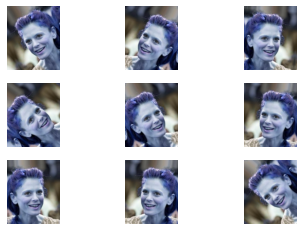

In [ ]:
first_image = X[1]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (218, 178, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(218, 178, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 218, 178, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 218, 178, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 218, 178, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 218, 178, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model


In [ ]:
initial_epochs = 10
X_val = np.array(X_val)
y_val = np.array(y_val)
loss0, accuracy0 = model.evaluate(X_val,y_val)

25/25 [==============================] - 23s 900ms/step - loss: 0.6802 - accuracy: 0.6338


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
history = model.fit(X_train,y_train,epochs=10, validation_data=(X_val,y_val))

Epoch 1/10
100/100 [==============================] - 123s 1s/step - loss: 0.6369 - accuracy: 0.6828 - val_loss: 0.5155 - val_accuracy: 0.8163
Epoch 2/10
100/100 [==============================] - 123s 1s/step - loss: 0.5300 - accuracy: 0.7778 - val_loss: 0.4282 - val_accuracy: 0.8462
Epoch 3/10
100/100 [==============================] - 122s 1s/step - loss: 0.4690 - accuracy: 0.8191 - val_loss: 0.3866 - val_accuracy: 0.8625
Epoch 4/10
100/100 [==============================] - 122s 1s/step - loss: 0.4338 - accuracy: 0.8278 - val_loss: 0.3587 - val_accuracy: 0.8675
Epoch 5/10
100/100 [==============================] - 122s 1s/step - loss: 0.4105 - accuracy: 0.8406 - val_loss: 0.3371 - val_accuracy: 0.8737
Epoch 6/10
100/100 [==============================] - 122s 1s/step - loss: 0.3906 - accuracy: 0.8456 - val_loss: 0.3190 - val_accuracy: 0.8763
Epoch 7/10
100/100 [==============================] - 122s 1s/step - loss: 0.3747 - accuracy: 0.8534 - val_loss: 0.3158 - val_accuracy: 0.8788

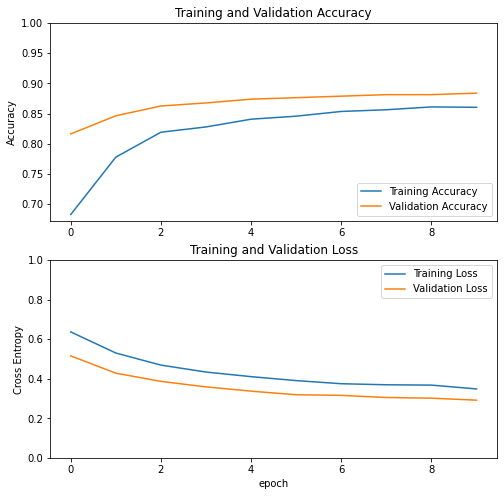

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train,y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val,y_val))

Epoch 10/20
100/100 [==============================] - 195s 2s/step - loss: 0.3469 - accuracy: 0.8521 - val_loss: 0.2429 - val_accuracy: 0.9062
Epoch 11/20
100/100 [==============================] - 189s 2s/step - loss: 0.2957 - accuracy: 0.8858 - val_loss: 0.2735 - val_accuracy: 0.8888
Epoch 12/20
100/100 [==============================] - 190s 2s/step - loss: 0.2453 - accuracy: 0.9079 - val_loss: 0.1884 - val_accuracy: 0.9325
Epoch 13/20
100/100 [==============================] - 189s 2s/step - loss: 0.2208 - accuracy: 0.9101 - val_loss: 0.1831 - val_accuracy: 0.9300
Epoch 14/20
100/100 [==============================] - 189s 2s/step - loss: 0.1930 - accuracy: 0.9228 - val_loss: 0.2011 - val_accuracy: 0.9250
Epoch 15/20
100/100 [==============================] - 189s 2s/step - loss: 0.2113 - accuracy: 0.9128 - val_loss: 0.1736 - val_accuracy: 0.9362
Epoch 16/20
100/100 [==============================] - 190s 2s/step - loss: 0.1766 - accuracy: 0.9313 - val_loss: 0.1695 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

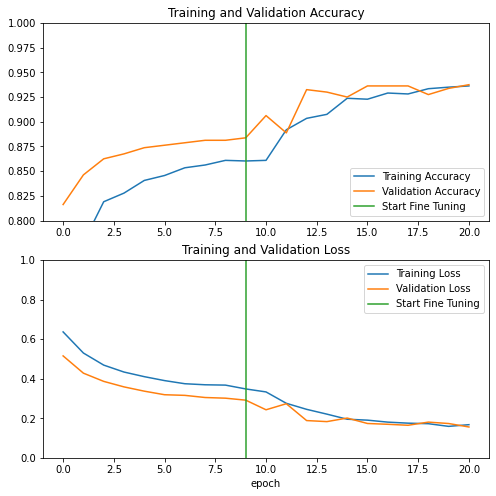

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)
loss, accuracy = model.evaluate(X_test,y_test)
print('Test accuracy :', accuracy)

32/32 [==============================] - 29s 872ms/step - loss: 0.1523 - accuracy: 0.9430
Test accuracy : 0.9430000185966492


In [ ]:
model.save('/content/drive/MyDrive/ML_UCL/celeba/gender_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_UCL/celeba/gender_model/assets
